This document focuses on analyzing the results and presenting the diagrams for the network model.     
The network model contains two intersections consisting of one east-west road and two north-south roads together.    
as control variables to reduce the pressure on the program to run and increase the efficiency of the algorithm. In this model, all roads will be considered for one-way traffic only.   


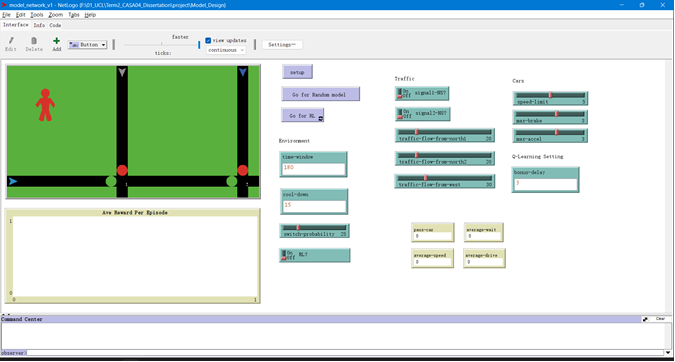

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium

## Functions

In [3]:
def getTrend(df_bd):
    # List of columns to plot
    columns_to_plot = ['avg_reward', 'pass_car', 'average_speed', 'average_wait', 'average_drive']

    # Plot each column separately
    plt.figure(figsize=(12, 10))

    for i, column in enumerate(columns_to_plot, 1):
        plt.subplot(5, 1, i)
        plt.scatter(df_bd.index, df_bd[column], marker='o',s=1)
        plt.xlabel('step')
        plt.ylabel(column)
        plt.title(f'{column} trend during training')
        plt.grid(True, linestyle='--')
        # Fit a linear regression line
        z = np.polyfit(df_bd.index, df_bd[column], 5)
        p = np.poly1d(z)
        plt.plot(df_bd.index, p(df_bd.index), color='red')


    plt.tight_layout()
    plt.show()

In [4]:
def readBD_CSV(filepath):

    # Define a mapping of current column names to standardized column names
    column_mapping = {
        '[run number]': 'run_number',
        'cool-down': 'cool_down',
        'traffic-flow-from-west': 'traffic_flow_from_west',
        'max-accel': 'max_accel',
        'bonus-delay': 'bonus_delay',
        'traffic-flow-from-north1': 'traffic_flow_from_north1',
        'traffic-flow-from-north2': 'traffic_flow_from_north2',
        'time-window': 'time_window',
        'signal2-NS?': 'signal2_NS',
        'switch-probability': 'switch_probability',
        'speed-limit': 'speed_limit',
        'max-brake': 'max_brake',
        'signal1-NS?': 'signal1_NS',
        'RL?': 'RL',
        '[step]': 'step',
        'time': 'time',
        'pass-car': 'pass_car',
        'avg_reward': 'avg_reward',
        'average-speed': 'average_speed',
        'average-wait': 'average_wait',
        'average-drive': 'average_drive'
    }

    df = pd.read_csv(filepath)
    df.rename(columns=column_mapping, inplace=True)

    # Extract the specified columns and create a new DataFrame
    selected_columns = ['step', 'time', 'pass_car', 'avg_reward', 'average_speed', 'average_wait', 'average_drive']
    df = df[selected_columns]

    # Sort the new DataFrame by the 'step' column in ascending order
    df.sort_values(by='step', inplace=True)

    # Get the index of rows where 'time' is 0
    time_zero_indices = df[df['time'] == 0].index
    time_zero_indices = time_zero_indices[1:]

    # Extract the rows before the rows with 'time' equal to 0
    rows_before_time_zero = df.loc[time_zero_indices - 1]

    # Save the result as a new DataFrame
    result_df = rows_before_time_zero.copy()

    # Recompute the DataFrame index
    result_df.reset_index(drop=True, inplace=True)

    return result_df

In [5]:
def getAnalysis(df):
    # Select the last 1000 records
    last_1000_records = df.tail(1000)

    # Calculate statistics for each column
    pass_car_stats = {
        'max': last_1000_records['pass_car'].max(),
        'min': last_1000_records['pass_car'].min(),
        'mean': last_1000_records['pass_car'].mean(),
        'std': last_1000_records['pass_car'].std()
    }

    avg_reward_stats = {
        'max': last_1000_records['avg_reward'].max(),
        'min': last_1000_records['avg_reward'].min(),
        'mean': last_1000_records['avg_reward'].mean(),
        'std': last_1000_records['avg_reward'].std()
    }

    average_speed_stats = {
        'max': last_1000_records['average_speed'].max(),
        'min': last_1000_records['average_speed'].min(),
        'mean': last_1000_records['average_speed'].mean(),
        'std': last_1000_records['average_speed'].std()
    }

    average_wait_stats = {
        'max': last_1000_records['average_wait'].max(),
        'min': last_1000_records['average_wait'].min(),
        'mean': last_1000_records['average_wait'].mean(),
        'std': last_1000_records['average_wait'].std()
    }

    average_drive_stats = {
        'max': last_1000_records['average_drive'].max(),
        'min': last_1000_records['average_drive'].min(),
        'mean': last_1000_records['average_drive'].mean(),
        'std': last_1000_records['average_drive'].std()
    }

    # Print the calculated statistics
    print("avg_reward -", avg_reward_stats)
    print("pass_car -", pass_car_stats)
    print("average_speed -", average_speed_stats)
    print("average_wait -", average_wait_stats)
    print("average_drive -", average_drive_stats)

    
    # List of columns to plot
    columns_to_plot = [ 'avg_reward', 'pass_car','average_speed', 'average_wait', 'average_drive']

    # Plot the box plots
    plt.figure(figsize=(12, 6))

    for i, column in enumerate(columns_to_plot, 1):
        plt.subplot(1, 5, i)
        plt.boxplot(last_1000_records[column])
        plt.xlabel(column)
        plt.ylabel('Values')
        plt.title(f'Box Plot for {column}')
        plt.grid(True, axis='y', linestyle='--')

        # Calculate statistics for each column
        column_max = last_1000_records[column].max()
        column_min = last_1000_records[column].min()
        column_mean = last_1000_records[column].mean()

        # Add text annotations for mean, max, and min values
        plt.text(1, column_mean, f"Mean: {column_mean:.2f}", ha='center', va='bottom', color='red')
        plt.text(1, column_max, f"Max: {column_max}", ha='center', va='bottom', color='blue')
        plt.text(1, column_min, f"Min: {column_min}", ha='center', va='top', color='green')

    plt.tight_layout()
    plt.show()

## Pre-define model

In this mode, Traffic Lights 1 and 2 will have a 15ticks toggle cooldown, with a 25% probability of toggling the traffic light state every tick while it is toggleable.

In [6]:
# Define a mapping of current column names to standardized column names
column_mapping = {
    '[run number]': 'run_number',
    'cool-down': 'cool_down',
    'traffic-flow-from-west': 'traffic_flow_from_west',
    'max-accel': 'max_accel',
    'bonus-delay': 'bonus_delay',
    'traffic-flow-from-north1': 'traffic_flow_from_north1',
    'traffic-flow-from-north2': 'traffic_flow_from_north2',
    'time-window': 'time_window',
    'signal2-NS?': 'signal2_NS',
    'switch-probability': 'switch_probability',
    'speed-limit': 'speed_limit',
    'max-brake': 'max_brake',
    'signal1-NS?': 'signal1_NS',
    'RL?': 'RL',
    '[step]': 'step',
    'pass-car': 'pass_car',
    'average-speed': 'average_speed',
    'average-wait': 'average_wait',
    'average-drive': 'average_drive'
}

csv_pre = pd.read_csv("./model/network_data_random.csv")
# Rename the columns using the mapping
csv_pre.rename(columns=column_mapping, inplace=True)
csv_pre.info()
csv_pre.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   run_number                10001 non-null  int64  
 1   cool_down                 10001 non-null  int64  
 2   traffic_flow_from_west    10001 non-null  int64  
 3   max_accel                 10001 non-null  int64  
 4   bonus_delay               10001 non-null  int64  
 5   traffic_flow_from_north1  10001 non-null  int64  
 6   traffic_flow_from_north2  10001 non-null  int64  
 7   time_window               10001 non-null  int64  
 8   signal2_NS                10001 non-null  bool   
 9   switch_probability        10001 non-null  int64  
 10  speed_limit               10001 non-null  int64  
 11  max_brake                 10001 non-null  int64  
 12  signal1_NS                10001 non-null  bool   
 13  RL                        10001 non-null  bool   
 14  step  

,run_number,cool_down,traffic_flow_from_west,max_accel,bonus_delay,traffic_flow_from_north1,traffic_flow_from_north2,time_window,signal2_NS,switch_probability,speed_limit,max_brake,signal1_NS,RL,step,pass_car,average_speed,average_wait,average_drive
0,1,15,30,3,1,20,20,180,False,25,5,3,False,False,0,0,0.000000,0.000000,0.000000
1,1,15,30,3,1,20,20,180,False,25,5,3,False,False,1,96,1.972266,23.791667,3.927083
2,1,15,30,3,1,20,20,180,False,25,5,3,False,False,2,109,2.364378,10.532110,3.422018
3,1,15,30,3,1,20,20,180,False,25,5,3,False,False,3,91,2.194522,12.329670,3.483516
4,1,15,30,3,1,20,20,180,False,25,5,3,False,False,4,86,2.705870,8.046512,3.220930


In [7]:
# Remove the first row (index 0) from the DataFrame
csv_pre = csv_pre.iloc[1:]

# Calculate mean for each column
mean_pass_car = csv_pre['pass_car'].mean()
mean_average_speed = csv_pre['average_speed'].mean()
mean_average_wait = csv_pre['average_wait'].mean()
mean_average_drive = csv_pre['average_drive'].mean()

# Calculate maximum for each column
max_pass_car = csv_pre['pass_car'].max()
max_average_speed = csv_pre['average_speed'].max()
max_average_wait = csv_pre['average_wait'].max()
max_average_drive = csv_pre['average_drive'].max()

# Calculate minimum for each column
min_pass_car = csv_pre['pass_car'].min()
min_average_speed = csv_pre['average_speed'].min()
min_average_wait = csv_pre['average_wait'].min()
min_average_drive = csv_pre['average_drive'].min()

# Calculate standard deviation for each column
std_pass_car = csv_pre['pass_car'].std()
std_average_speed = csv_pre['average_speed'].std()
std_average_wait = csv_pre['average_wait'].std()
std_average_drive = csv_pre['average_drive'].std()

# Print the results
print("pass_car - Mean:", mean_pass_car, " Max:", max_pass_car, " Min:", min_pass_car, " Std:", std_pass_car)
print("average_speed - Mean:", mean_average_speed, " Max:", max_average_speed, " Min:", min_average_speed, " Std:", std_average_speed)
print("average_wait - Mean:", mean_average_wait, " Max:", max_average_wait, " Min:", min_average_wait, " Std:", std_average_wait)
print("average_drive - Mean:", mean_average_drive, " Max:", max_average_drive, " Min:", min_average_drive, " Std:", std_average_drive)

pass_car - Mean: 93.4779  Max: 136  Min: 34  Std: 12.278484748077426
average_speed - Mean: 2.348260315064718  Max: 4.3960784313725485  Min: 1.5199942540047104  Std: 0.312803712999254
average_wait - Mean: 14.817746145516104  Max: 55.75714285714286  Min: 0.0294117647058823  Std: 5.365306301462226
average_drive - Mean: 3.6541761576291254  Max: 4.652173913043479  Min: 2.191489361702128  Std: 0.33026138285002354


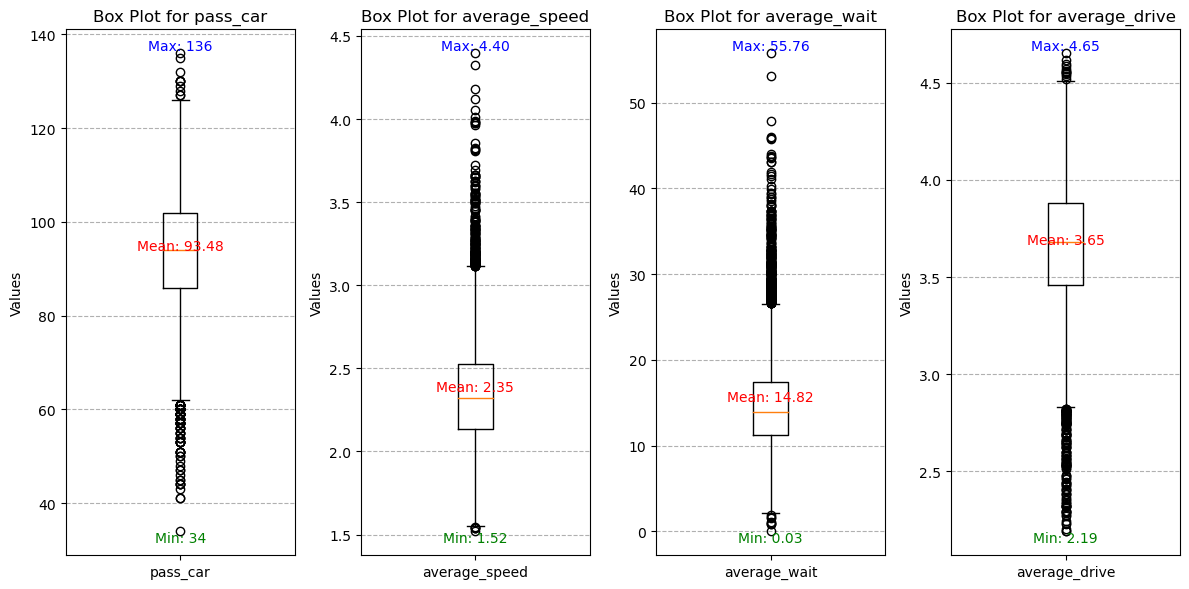

In [8]:
# Convert the specified columns to numeric data types
csv_pre['pass_car'] = pd.to_numeric(csv_pre['pass_car'])
csv_pre['average_speed'] = pd.to_numeric(csv_pre['average_speed'])
csv_pre['average_wait'] = pd.to_numeric(csv_pre['average_wait'])
csv_pre['average_drive'] = pd.to_numeric(csv_pre['average_drive'])

# Calculate the statistics for each column
pass_car_mean = csv_pre['pass_car'].mean()
pass_car_max = csv_pre['pass_car'].max()
pass_car_min = csv_pre['pass_car'].min()

average_speed_mean = csv_pre['average_speed'].mean()
average_speed_max = csv_pre['average_speed'].max()
average_speed_min = csv_pre['average_speed'].min()

average_wait_mean = csv_pre['average_wait'].mean()
average_wait_max = csv_pre['average_wait'].max()
average_wait_min = csv_pre['average_wait'].min()

average_drive_mean = csv_pre['average_drive'].mean()
average_drive_max = csv_pre['average_drive'].max()
average_drive_min = csv_pre['average_drive'].min()

# Plot
plt.figure(figsize=(12, 6))

# Box plot for 'pass_car'
plt.subplot(1, 4, 1)
plt.boxplot(csv_pre['pass_car'])
plt.xticks([1], ['pass_car'])
plt.ylabel('Values')
plt.title('Box Plot for pass_car')
plt.grid(True, axis='y', linestyle='--')
# Display mean value on the 'pass_car' box plot
plt.text(1, pass_car_mean, f"Mean: {pass_car_mean:.2f}", ha='center', va='bottom', color='red')
plt.text(1, pass_car_max, f"Max: {pass_car_max}", ha='center', va='bottom', color='blue')
plt.text(1, pass_car_min, f"Min: {pass_car_min}", ha='center', va='top', color='green')

# Box plots for other columns
columns_to_plot = ['average_speed', 'average_wait', 'average_drive']
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(1, 4, i+1)
    plt.boxplot(csv_pre[column])
    plt.xticks([1], [column])
    plt.ylabel('Values')
    plt.title(f'Box Plot for {column}')
    plt.grid(True, axis='y', linestyle='--')
    # Display mean value on the box plot
    plt.text(1, eval(f"{column}_mean"), f"Mean: {eval(f'{column}_mean'):.2f}", ha='center', va='bottom', color='red')
    plt.text(1, eval(f"{column}_max"), f"Max: {eval(f'{column}_max'):.2f}", ha='center', va='bottom', color='blue')
    plt.text(1, eval(f"{column}_min"), f"Min: {eval(f'{column}_min'):.2f}", ha='center', va='top', color='green')

plt.tight_layout()
plt.show()

## RL

### Bonus Delay 1

In [9]:
db_1 = readBD_CSV('./model/network_data_RL_BD_1.csv')

avg_reward - {'max': 0.8000801677959242, 'min': 0.2469625374259178, 'mean': 0.5218900234300828, 'std': 0.09025041937191709}
pass_car - {'max': 146, 'min': 83, 'mean': 114.781, 'std': 9.52111814288063}
average_speed - {'max': 3.506877087004658, 'min': 1.7064770945703032, 'mean': 2.389775475537322, 'std': 0.24473378081503938}
average_wait - {'max': 20.628865979381445, 'min': 3.2149532710280373, 'mean': 9.38274750120201, 'std': 2.4839879794903585}
average_drive - {'max': 4.660869565217391, 'min': 2.696969696969697, 'mean': 3.7634047747432082, 'std': 0.25348603046282714}


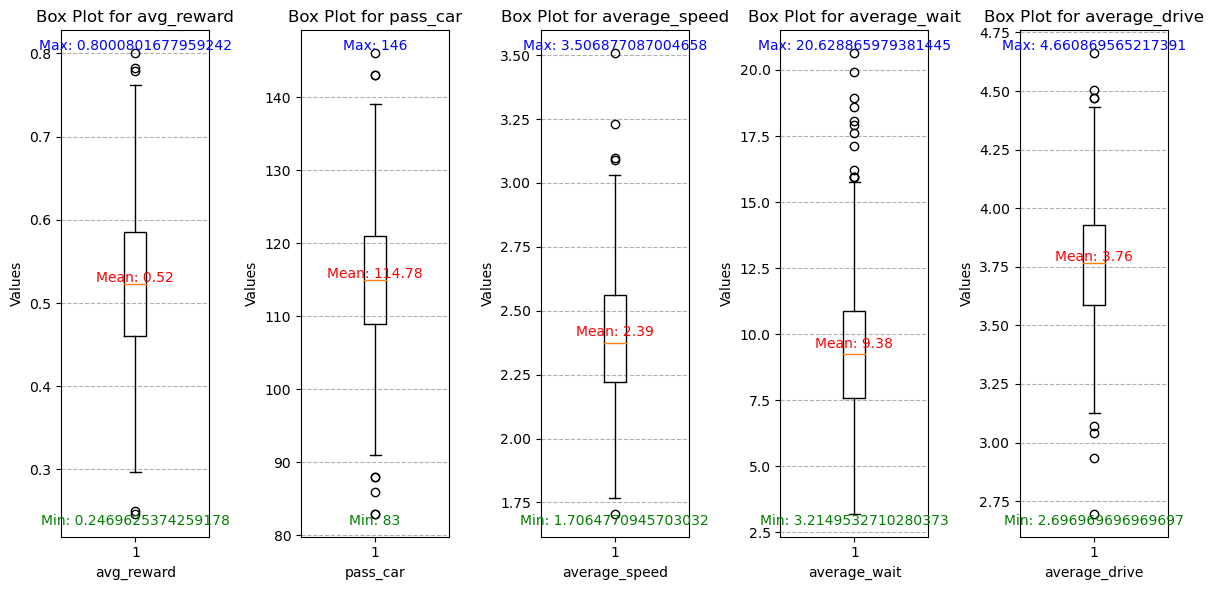

In [11]:
getAnalysis(db_1)

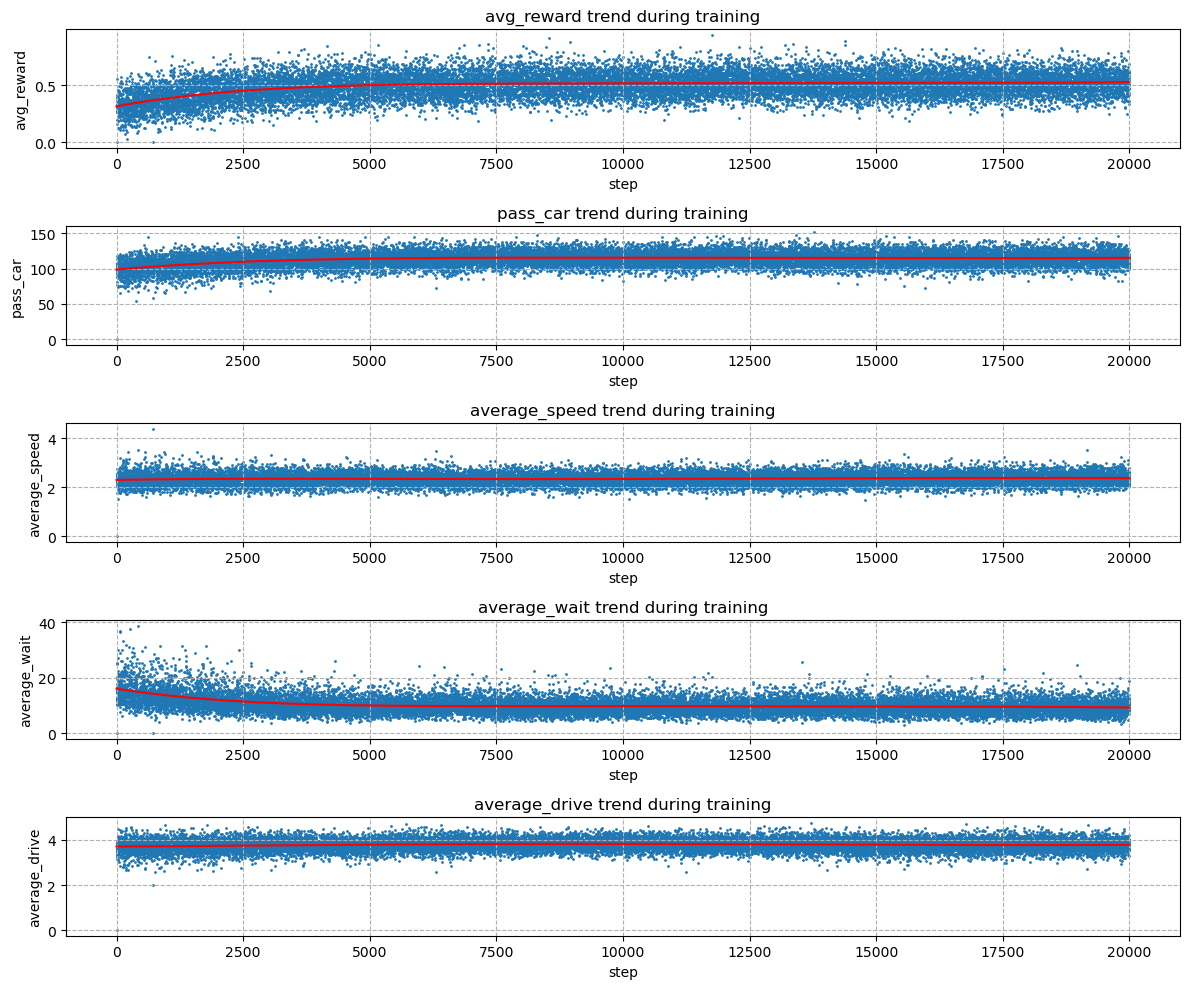

In [12]:
getTrend(db_1)

### Bonus Delay 2

In [13]:
db_2 = readBD_CSV('./model/network_data_RL_BD_2.csv')

In [14]:
db_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21818 entries, 0 to 21817
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   step           21818 non-null  int64  
 1   time           21818 non-null  int64  
 2   pass_car       21818 non-null  int64  
 3   avg_reward     21818 non-null  float64
 4   average_speed  21818 non-null  float64
 5   average_wait   21818 non-null  float64
 6   average_drive  21818 non-null  float64
dtypes: float64(4), int64(3)
memory usage: 1.2 MB


avg_reward - {'max': 1.3772980934962158, 'min': 0.3716351197378928, 'mean': 0.8370900971781291, 'std': 0.15140430547846112}
pass_car - {'max': 140, 'min': 79, 'mean': 109.605, 'std': 9.25411333481569}
average_speed - {'max': 3.1152116683956783, 'min': 1.6687949306784486, 'mean': 2.31583392777087, 'std': 0.2368736790917086}
average_wait - {'max': 23.820224719101123, 'min': 4.512820512820513, 'mean': 10.79116818803203, 'std': 2.988511066130168}
average_drive - {'max': 4.574074074074074, 'min': 2.8875, 'mean': 3.805039050871891, 'std': 0.25820639755220154}


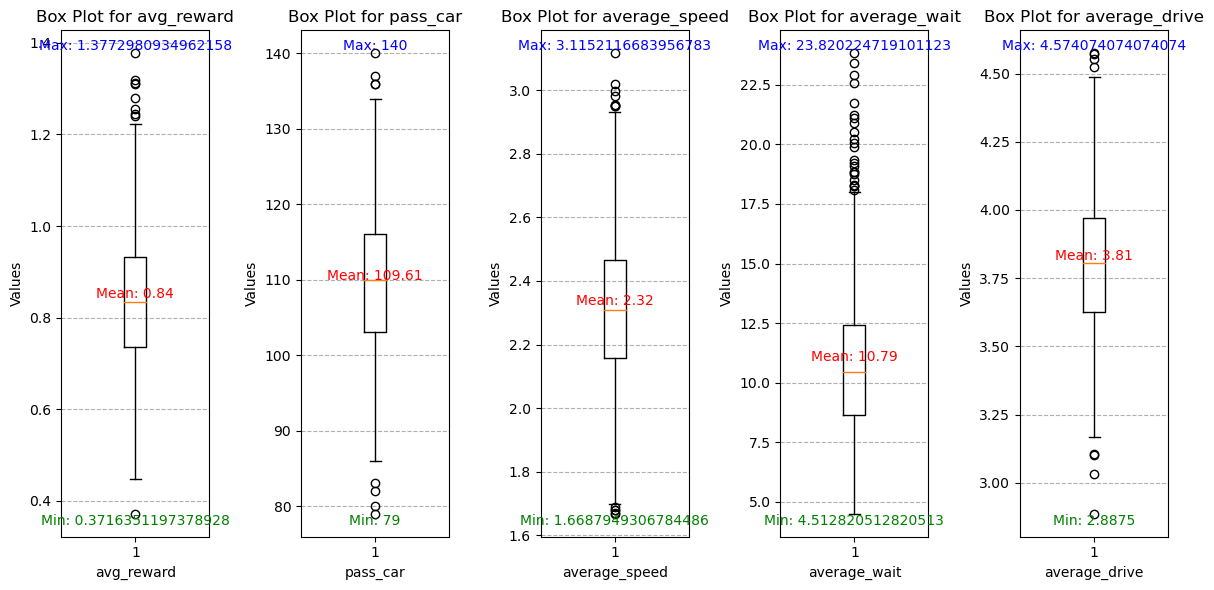

In [15]:
getAnalysis(db_2)

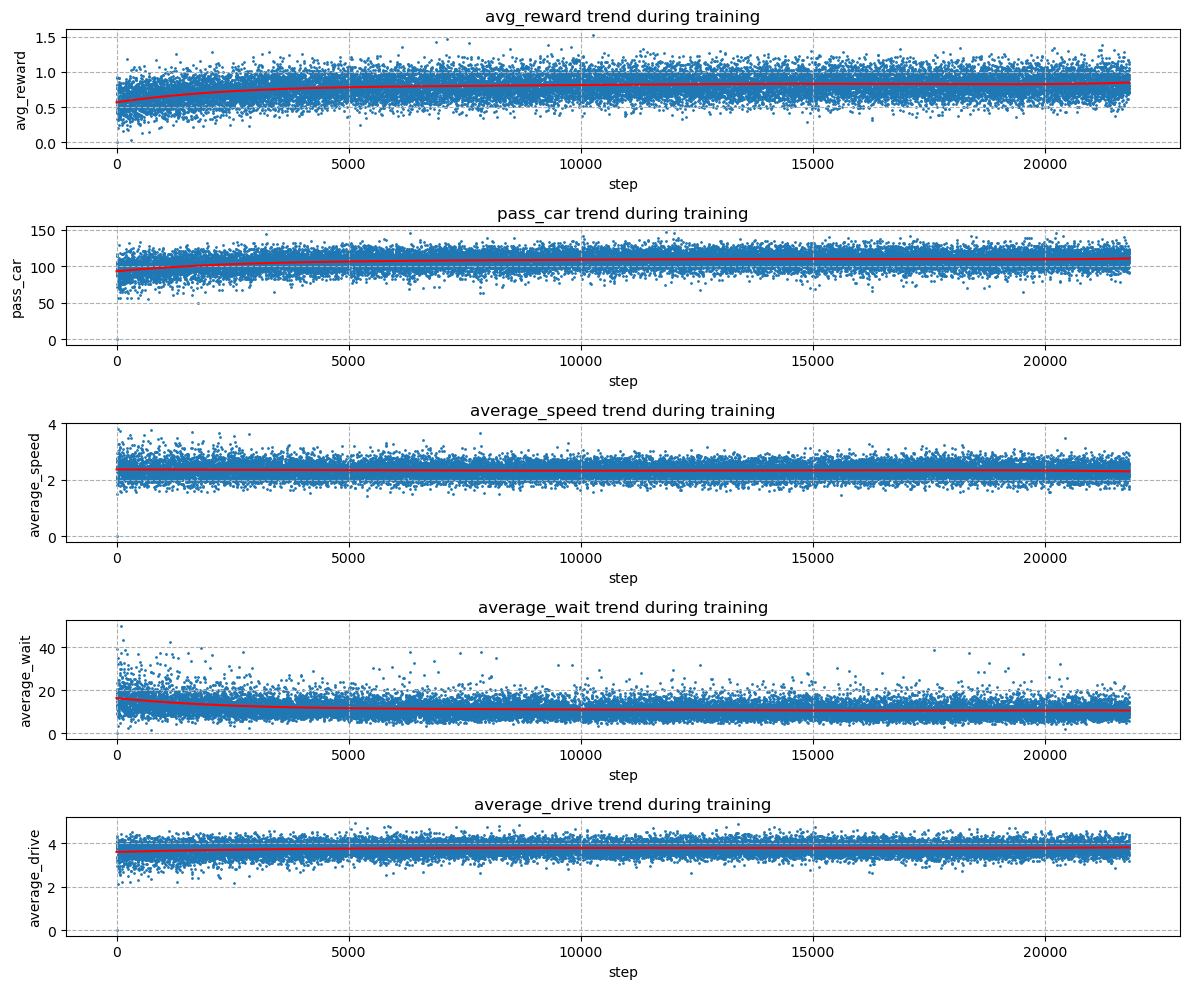

In [16]:
getTrend(db_2)

### Bonus Delay 3

In [17]:
db_3 = readBD_CSV('./model/network_data_RL_BD_3.csv')

In [18]:
db_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23999 entries, 0 to 23998
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   step           23999 non-null  int64  
 1   time           23999 non-null  int64  
 2   pass_car       23999 non-null  int64  
 3   avg_reward     23999 non-null  float64
 4   average_speed  23999 non-null  float64
 5   average_wait   23999 non-null  float64
 6   average_drive  23999 non-null  float64
dtypes: float64(4), int64(3)
memory usage: 1.3 MB


avg_reward - {'max': 2.1409130207228277, 'min': 0.7849106166371448, 'mean': 1.3710261091061966, 'std': 0.19811909093159266}
pass_car - {'max': 130, 'min': 80, 'mean': 104.548, 'std': 8.638768681028814}
average_speed - {'max': 3.250299335470901, 'min': 1.739898994510058, 'mean': 2.4424151922599924, 'std': 0.25246361519457594}
average_wait - {'max': 25.815217391304348, 'min': 4.235849056603773, 'mean': 10.03273087230782, 'std': 2.681020923491141}
average_drive - {'max': 4.655913978494624, 'min': 2.7850467289719627, 'mean': 3.6580327005123454, 'std': 0.2638699637050865}


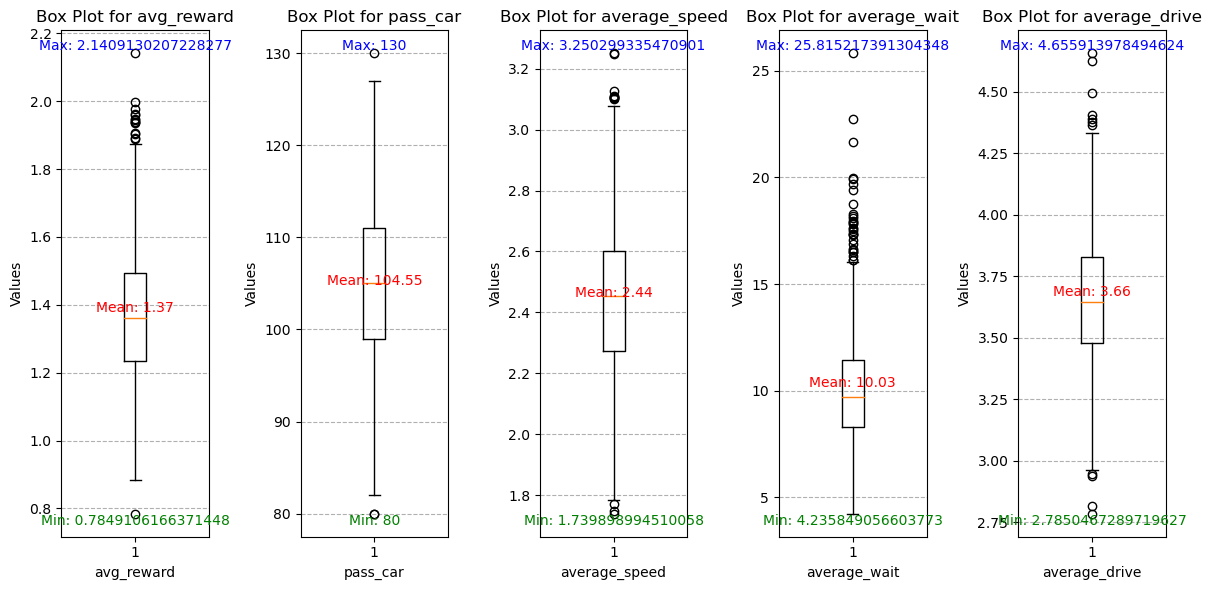

In [19]:
getAnalysis(db_3)

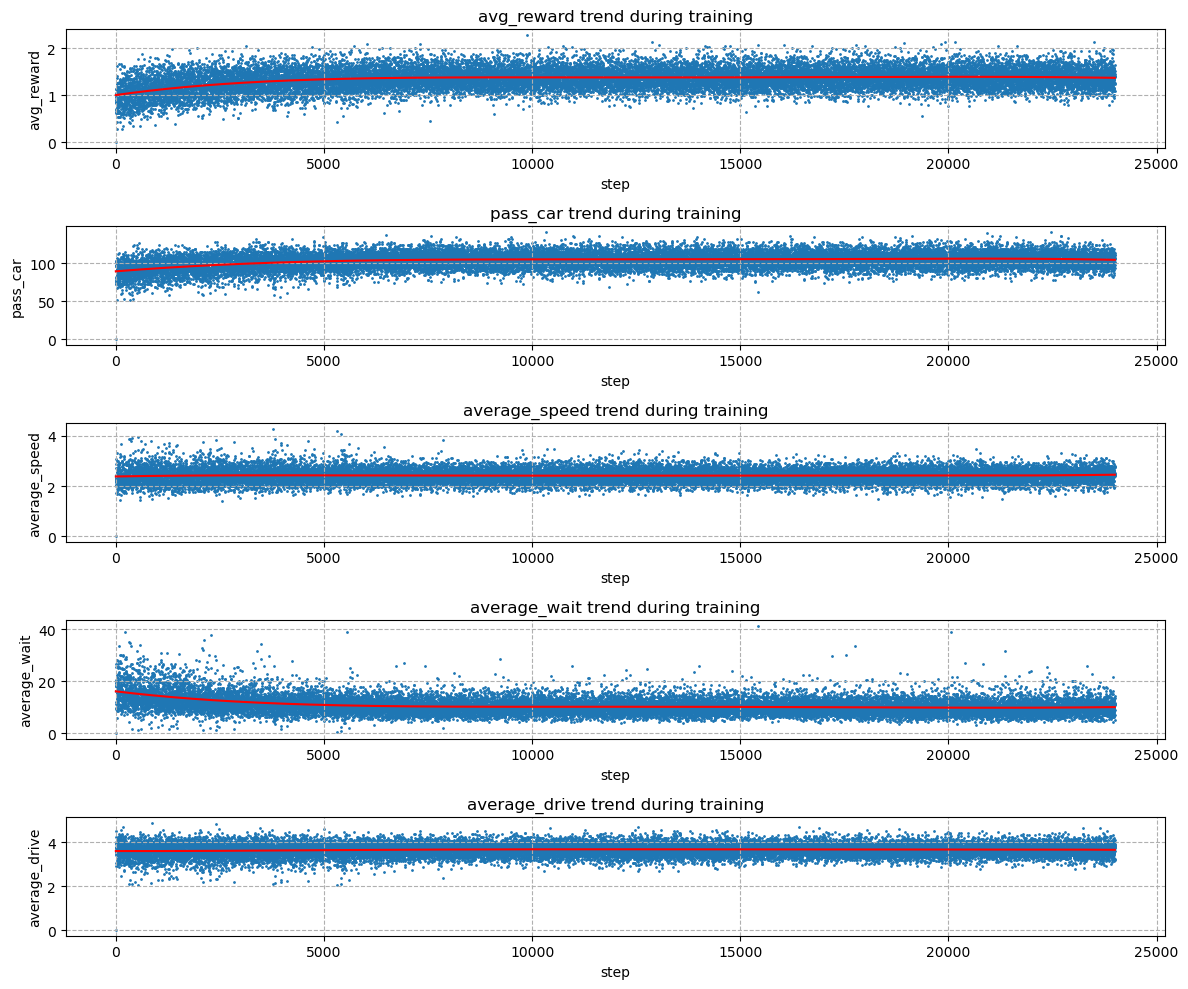

In [20]:
getTrend(db_3)

### Analysis

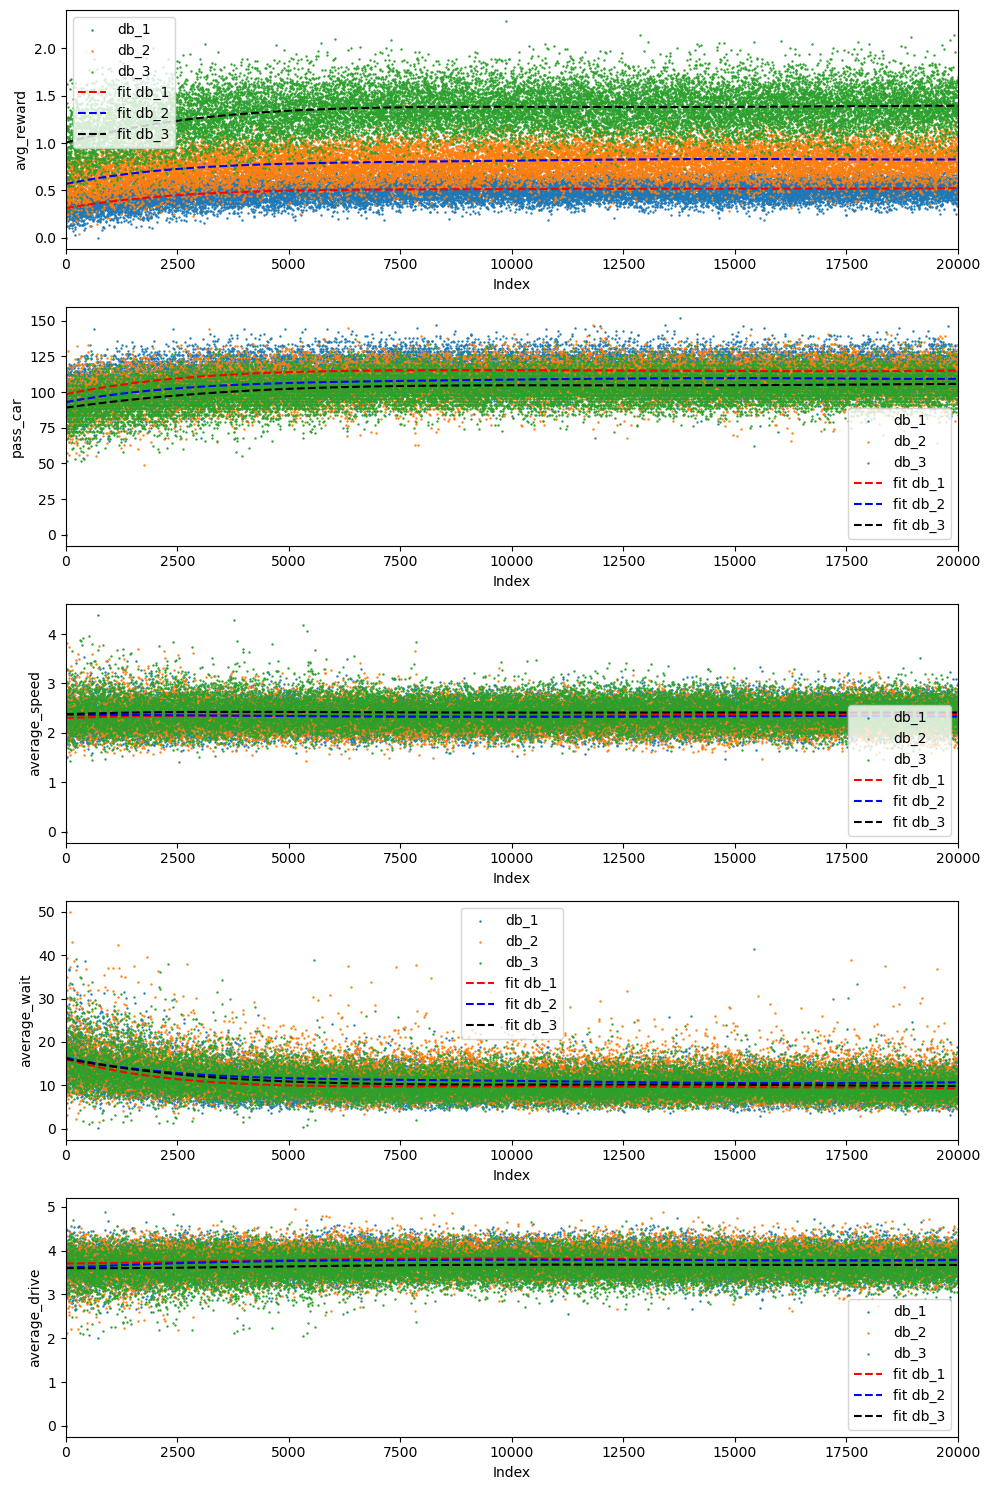

In [21]:
# 列表中的列名
columns = ['avg_reward', 'pass_car', 'average_speed', 'average_wait', 'average_drive']

# 创建一个包含5个子图的画布
fig, axes = plt.subplots(5, 1, figsize=(10, 15))

# 循环处理每一列
for idx, column in enumerate(columns):
    # 在每个子图中绘制三个df的数据
    x1 = np.arange(len(db_1))
    x2 = np.arange(len(db_2))
    x3 = np.arange(len(db_3))
    y1 = db_1[column]
    y2 = db_2[column]
    y3 = db_3[column]

    # 使用np.polyfit计算拟合多项式系数
    coeffs1 = np.polyfit(x1, y1, 5)
    coeffs2 = np.polyfit(x2, y2, 5)
    coeffs3 = np.polyfit(x3, y3, 5)

    # 计算拟合值
    poly1 = np.poly1d(coeffs1)
    poly2 = np.poly1d(coeffs2)
    poly3 = np.poly1d(coeffs3)

    # 绘制折线图
    axes[idx].scatter(x1, y1, label='db_1', marker='o', s=0.5)
    axes[idx].scatter(x2, y2, label='db_2', marker='o', s=0.5)
    axes[idx].scatter(x3, y3, label='db_3', marker='o', s=0.5)

    # 绘制拟合曲线
    x_fit1 = np.linspace(0, len(db_1) - 1, 100)
    x_fit2 = np.linspace(0, len(db_2) - 1, 100)
    x_fit3 = np.linspace(0, len(db_3) - 1, 100)
    axes[idx].plot(x_fit1, poly1(x_fit1), linestyle='--', label='fit db_1', color = 'red')
    axes[idx].plot(x_fit2, poly2(x_fit2), linestyle='--', label='fit db_2', color = 'blue')
    axes[idx].plot(x_fit3, poly3(x_fit3), linestyle='--', label='fit db_3', color = 'black')

    axes[idx].set_xlabel('Index')
    axes[idx].set_ylabel(column)
    # 设置x轴范围为0到20000
    axes[idx].set_xlim(0, 20000)
    axes[idx].legend()

plt.tight_layout()
plt.show()

## Pattern of RL

In [87]:
df = pd.read_csv('./model/network_data_RL_BD_1_signal_pattern.csv')
# Define a mapping of current column names to standardized column names
column_mapping = {
        '[run number]': 'run_number',
        'cool-down': 'cool_down',
        'traffic-flow-from-west': 'traffic_flow_from_west',
        'max-accel': 'max_accel',
        'bonus-delay': 'bonus_delay',
        'traffic-flow-from-north1': 'traffic_flow_from_north1',
        'traffic-flow-from-north2': 'traffic_flow_from_north2',
        'time-window': 'time_window',
        'signal2-NS?': 'signal2_NS',
        'switch-probability': 'switch_probability',
        'speed-limit': 'speed_limit',
        'max-brake': 'max_brake',
        'signal1-NS?': 'signal1_NS',
        'RL?': 'RL',
        '[step]': 'step',
        'time': 'time',
        'pass-car': 'pass_car',
        'avg_reward': 'avg_reward',
        'average-speed': 'average_speed',
        'average-wait': 'average_wait',
        'average-drive': 'average_drive',
        'singal1_EW': 'signal1_EW',
        'singal2_EW': 'signal2_EW'
    }

df.rename(columns=column_mapping, inplace=True)

# Extract the specified columns and create a new DataFrame
selected_columns = ['step', 'time', 'signal1_EW', 'signal2_EW']
df = df[selected_columns]

# Sort the new DataFrame by the 'step' column in ascending order
df.sort_values(by='step', inplace=True)

In [98]:
df['signal1_EW'] = df['signal1_EW'].replace(0, -1)
df['signal2_EW'] = df['signal2_EW'].replace(0, -1)

df.head()

,step,time,signal1_EW,signal2_EW
0,0,0,1,1
1,1,2,1,1
2,2,3,1,1
3,3,4,1,1
4,4,5,1,1


In [113]:
time_zero_indices = df[df['time'] == 0].index
time_zero_indices[-1000]

2528821

In [137]:
last_1000_cycles = df.loc[time_zero_indices[-500]:]
result_df = last_1000_cycles.groupby('time')[['signal1_EW', 'signal2_EW']].mean()
result_df = result_df.reset_index()

In [138]:
last_1000_cycles

,step,time,signal1_EW,signal2_EW
2618821,2618821,0,1,1
2618822,2618822,1,1,1
2618823,2618823,2,1,1
2618824,2618824,3,1,1
2618825,2618825,4,1,1
...,...,...,...,...
2708638,2708638,188,1,-1
2708639,2708639,189,1,-1
2708640,2708640,190,1,-1
2708641,2708641,0,1,1


In [139]:
result_df.describe()

,time,signal1_EW,signal2_EW
count,180.000000,180.000000,180.000000
mean,95.000000,-0.026365,-0.003317
std,55.556102,0.050617,0.032438
min,0.000000,-0.122244,-0.062124
25%,47.500000,-0.042084,-0.024533
50%,95.000000,-0.010020,-0.006012
75%,142.500000,0.000000,0.024048
max,190.000000,0.048000,0.050100


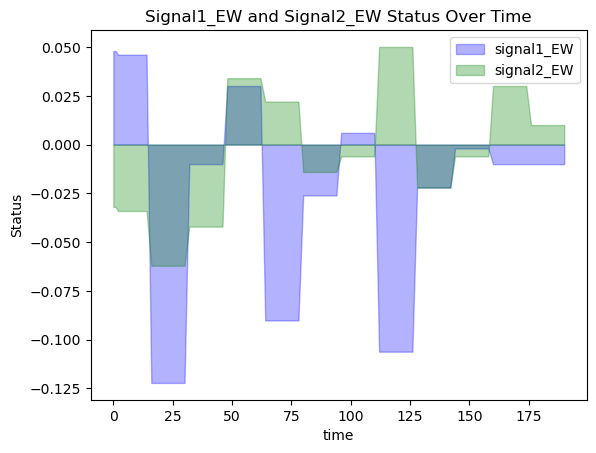

In [140]:
# 提取time、signal1_EW和signal2_EW的值
time = result_df['time']
signal1_EW = result_df['signal1_EW']
signal2_EW = result_df['signal2_EW']

# 创建绘图
fig, ax = plt.subplots()

# 绘制signal1_EW的状态
ax.fill_between(time, signal1_EW, color='blue', alpha=0.3, label='signal1_EW')

# 绘制signal2_EW的状态
ax.fill_between(time, signal2_EW, color='green', alpha=0.3, label='signal2_EW')

# 设置图表标题和轴标签
ax.set_title('Signal1_EW and Signal2_EW Status Over Time')
ax.set_xlabel('time')
ax.set_ylabel('Status')

# 添加图例
ax.legend()

# 显示图表
plt.show()